# Precautionary Saving and Precautionary Wealth

### A notebook by [Mateo Velasquez-Giraldo](https://github.com/Mv77/)

This notebook reproduces the figures in Christopher D. Carroll and Miles S. Kimball's entry on [Precautionary Saving and Precautionary Wealth](http://www.econ2.jhu.edu/people/ccarroll/PalgravePrecautionary.pdf) in [The New Palgrave Dictionary of Economics](https://www.palgrave.com/gp/book/9781349951888), using tools from the [Econ-ARK](https://econ-ark.org/) project.

In [1]:
# Uninteresting setup of the computational environment 

!pip install econ-ark
!pip install numpy
!pip install matplotlib 
!pip install scipy 


from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
from HARK.distribution import DiscreteDistribution

import matplotlib.pyplot as plt
import numpy as np
mystr = lambda number : "{:.4f}".format(number)

from copy import copy

from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# Define parameters for two consumers,
# a perfect foresight one and one with shocks to income

# Import standard parameters
from HARK.ConsumptionSaving.ConsIndShockModel import init_idiosyncratic_shocks
IdiosyncDict = init_idiosyncratic_shocks

# Make modifications to fit our problem:

# No artificial borrowing constraint
IdiosyncDict["BoroCnstArt"] = None
# No unemployment
IdiosyncDict["UnempPrb"] = 0
# Ask HARK to compute the value function
IdiosyncDict["vFuncBool"] = True
# Turn off permanent income shocks
IdiosyncDict["PermShkStd"] = [0]

# For transitory shocks, to illustrate the problem, we want two possible
# values: a good and a bad one. This is most easily achieved by setting
# a large standard deviation (3) and telling HARK to approximate the
# distribution using only two points.
IdiosyncDict["TranShkStd"] = [3]
IdiosyncDict["TranShkCount"] = 2

# Create a copy with income uncertainty turned off, for comparison
PFDict = copy(IdiosyncDict)
PFDict["TranShkStd"] = [0]
PFDict["TranShkCount"] = 1

In [3]:
# Create and solve problems for the two consumers
IndShockConsumer = IndShockConsumerType(**IdiosyncDict)
IndShockConsumer.cycles = 2 # Make this type have a two-period horizon
IndShockConsumer.solve()

PFConsumer = IndShockConsumerType(**PFDict)
PFConsumer.cycles = 2
PFConsumer.solve()

## Figure 1: Marginal Utility of Assets and Consumption

Consider an agent facing the following dynamic problem expressed in recursive form:

\begin{equation}
\begin{split}
v_t(m_t) =& \max_{c_t} u(c_t) + \beta \mathbb{E}_t[v_{t+1}(R a_t + \tilde{y}_{t+1})] \\
& s.t & \\
\quad a_t =&  m_t - c_t,
\end{split}
\end{equation}

where $c_t$ represents consumption, $m_t$ beginning-of-period resources, $a_t$ end-of-period resources, and $\tilde{y}_{t+1}$ non-capital income in the next period, which is random from the perspective of this period.

The consumer chooses $c_t$ balancing two forces:
- The desire to consume his resources now, captured by $u(c_t)$.
- The benefit that he gets from saving his resources for next period, which we represent with $\omega(a_t)=\beta \mathbb{E}_t[v_{t+1}(R a_t + \tilde{y}_{t+1})]$.

Under standard assumptions, a requirement for optimality is that $$u'(m_t - a_t) = \omega'(a_t),$$ because this is the condition that says that a marginal dollar of resources would be equally valuable if it were spent (yielding $u'$) or saved (yielding $\omega^{\prime}$).

Figure 1 shows that uncertainty shifts up the expected marginal value of
resources on the next period, moving savings from $a^*$ (which would be
observed if income were certain at $\mathbb{E}_t[\tilde{y}_{t+1}]$) to 
$a^{**}$. This increase is the precautionary saving induced by the uncertainty 
around income.

In [4]:
# Figure 1

def uP(agent, c):
    '''
    Computes the marginal utility of consumption for an agent with
    CRRA utility at a consumption level c.
    '''
    return( c**(-agent.CRRA) )
    
def approxOmegaP(agent):
    '''
    Constructs a function that computes the discounted expected marginal value
    of wealth next period w'(a) for a grid of end of period assets using the
    fact that optimal consumption c() satisfies u'(c(m_t)) = w'_t(m_t - c(m_t))
    '''
    # Take the end-of-period assets grid from the consumer
    agrid = agent.aXtraGrid
    a_min = agrid[0]
    a_max = agrid[-1]
    # For each a, we need to find the implied m that generates it
    aux = lambda m: m - agent.solution[0].cFunc(m)
    m_grid = np.array([root_scalar(lambda m: a - aux(m), x0 = a_min, x1 = a_max).root
                       for a in agrid])
    
    # Then we can get consumption
    c_grid = agent.solution[0].cFunc(m_grid)
    # And with consmption, omega, since
    # omega prime is U' at the optimal C.
    omegaP_grid = uP(agent, c_grid)
    
    # We finally interpolate
    omegaP = interp1d(agrid, omegaP_grid, kind='cubic')
    
    return(omegaP)

def create_income_dstn(epsilon):
    
    # No permanent income shocks and 1+eps, 1-eps with half chance each for transitory.
    IncomeDstn = DiscreteDistribution(np.array([0.5,0.5]),
                                      [np.array([1,1]), np.array([1-epsilon,1+epsilon])])

def create_agents(CRRA,TranShkStd):
    
    # Copy base dictionaries
    un_dict = copy(IdiosyncDict)
    pf_dict = copy(PFDict)
    
    # Update CRRA
    un_dict['CRRA'] = CRRA
    pf_dict['CRRA'] = CRRA
    
    # Update transitory shock sd
    un_dict["TranShkStd"] = [TranShkStd]
    
    IndShockConsumer = IndShockConsumerType(**un_dict)
    IndShockConsumer.cycles = 2 # Make this type have a two-period horizon
    IndShockConsumer.solve()

    PFConsumer = IndShockConsumerType(**pf_dict)
    PFConsumer.cycles = 2
    PFConsumer.solve()
    
    return((IndShockConsumer, PFConsumer))

def fig1(CRRA, TranShkStd, m, a_m_min, a_m_max):
    
    # Create and solve consumers
    IndShockConsumer, PFConsumer = create_agents(CRRA, TranShkStd)
    
    # Approximate omega with and without uncertainty
    omegaP_uncert = approxOmegaP(IndShockConsumer)
    omegaP_PF = approxOmegaP(PFConsumer)

    # Consumption functions
    cPF = PFConsumer.solution[0].cFunc
    cIS = IndShockConsumer.solution[0].cFunc

    # Find intercepts with marginal utility
    a_star1 = m - cPF(m)
    a_star2 = m - cIS(m)

    # Grid for end-of-period assets
    a_grid = np.linspace(a_m_min*m, a_m_max*m, 50)

    # Line labels
    lab1 = '$\omega_t\'(a) = R \\beta E_t [v_{t+1}\'(aR + \\tilde{y}_{t+1})]$'
    lab2 = '$R \\beta v_{t+1}\'(aR + E_t[\\tilde{y}_{t+1}])$'
    lab3 = '$u\'(m_t-a)$'

    # Main lines

    # Omega uncertainty
    plt.figure(figsize = (10,8))
    plt.plot(a_grid, omegaP_uncert(a_grid), label = lab1)
    # Omega Perfect foresight
    plt.plot(a_grid, omegaP_PF(a_grid), label = lab2)
    # Marginal utility
    plt.plot(a_grid, uP(IndShockConsumer, m - a_grid), label = lab3)

    # Intersection lines
    ymin = plt.gca().get_ylim()[0]
    plt.plot([a_star1,a_star1],[ymin, uP(IndShockConsumer,m-a_star1)],'--k')
    plt.plot([a_star2,a_star2],[ymin, uP(IndShockConsumer,m-a_star2)],'--k')

    # x-axis ticks
    ax = plt.gca()
    ax.set_xticks([a_star1,a_star2])
    ax.set_xticklabels(["$a^*$","$a^{**}$"])

    # Text
    plt.xlabel('a', x=1)
    plt.legend()


In [10]:
# Widget

# CRRA - slider
crra_slider = widgets.FloatSlider(
                min = 1.02,
                max = 8,
                step = 0.01,
                value = 2,  # Default value
                continuous_update=False,
                readout_format ='.4f',
                description='$\\rho$')

# m - slider
m_slider = widgets.FloatSlider(min = 1.00,
                               max = 5,
                               step = 0.5,
                               value = 3,  # Default value
                               continuous_update=False,
                               readout_format ='.4f',
                               description='$m$')

# a_left_limit - slider
a_m_min_slider = widgets.FloatSlider(min = 0.05,
                                     max = 0.5,
                                     step = 0.01,
                                     value = 0.2,  # Default value
                                     continuous_update=False,
                                     readout_format ='.4f',
                                     description='$a_{\\min}/m$')

# a_right_limit - slider
a_m_max_slider = widgets.FloatSlider(min = 0.5,
                                     max = 0.99,
                                     step = 0.01,
                                     value = 0.8,  # Default value
                                     continuous_update=False,
                                     readout_format ='.4f',
                                     description='$a_{\\max}/m$')

# Shock std - slider
TranShkStd_slider = widgets.FloatSlider(min = 0.1,
                                        max = 5,
                                        step = 0.01,
                                        value = 1,  # Default value
                                        continuous_update=False,
                                        readout_format ='.4f',
                                        description='Shock s.d.')

interact(fig1,
         CRRA = crra_slider,
         TranShkStd = TranShkStd_slider,
         m = m_slider,
         a_m_min = a_m_min_slider,
         a_m_max = a_m_max_slider)

interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='$\\rho$', max=8.0, min=1.02…

<function __main__.fig1(CRRA, TranShkStd, m, a_m_min, a_m_max)>

## Figure 2

Figure 2 compares optimal consumption with and without income uncertainty.
The three most important facts to note are:
1. Consumption under uncertainty is always lower than its perfect-foresight counterpart.
2. The difference between them vanishes as market resources approach infinity.
3. Under uncertain future income, the consumption function is concave.

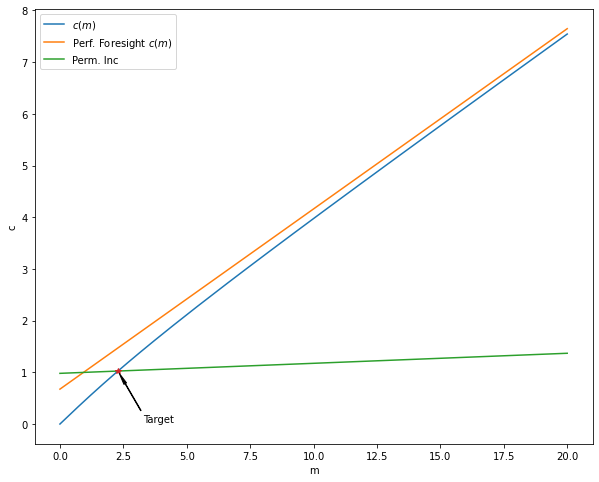

In [6]:
# Figure 2

# Define a function for the delta(m)=0 locus -- "sustainable" consumption
m0_locus = lambda m: m - (m-1)/(IdiosyncDict["Rfree"]/
                         IdiosyncDict["PermGroFac"][0])

# Define grid of market resources
m_max = 20
m_grid = np.linspace(IndShockConsumer.solution[0].mNrmMin, m_max, 500)

# Main lines

# Uncertainty solution
plt.figure(figsize = (10,8))
plt.plot(m_grid, IndShockConsumer.solution[0].cFunc(m_grid),
         label = '$c(m)$')
# Perfect foresight solution
plt.plot(m_grid, PFConsumer.solution[0].cFunc(m_grid),
         label = 'Perf. Foresight $c(m)$')
# Stable resource line
plt.plot(m_grid, m0_locus(m_grid), label = 'Perm. Inc')
# Target
targ = (IndShockConsumer.solution[0].mNrmSS,
        IndShockConsumer.solution[0].cFunc(IndShockConsumer.solution[0].mNrmSS))
plt.plot(targ[0], targ[1], '*')

# Annotations
plt.xlabel('m')
plt.ylabel('c')
plt.annotate('Target',
             xy = targ,
             xytext = (targ[0]+1., targ[1]-1),
             arrowprops=dict(facecolor='black', shrink=0.05,
                             headwidth = 3, width = 0.5))
plt.legend()

# Figure 3

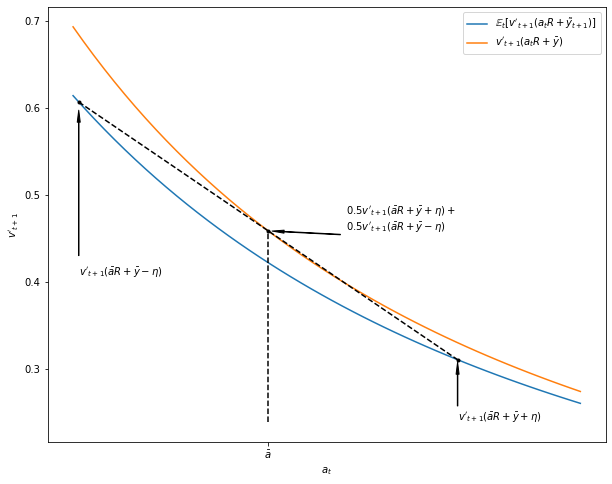

In [7]:
# If perfect foresight marginal value (blue) is convex, adding uncertainty increases marginal value (Jensen)
y_bar = 1
eta = 0.5

# Grid for end-of period assets
a_min = 0.5
a_max = 1.8
a_grid = np.linspace(a_min, a_max, 50)

# Extract the marginal t+1 value function from the PF agent
vPt1 = lambda a: PFConsumer.solution[1].vPfunc(PFConsumer.Rfree*a + y_bar)
# Define the expected value under uncertainty
vPt1_u = lambda a: 0.5*PFConsumer.solution[1].vPfunc(PFConsumer.Rfree*a + y_bar - eta) +\
                   0.5*PFConsumer.solution[1].vPfunc(PFConsumer.Rfree*a + y_bar + eta)

# Main lines
plt.figure(figsize = (10,8))

# V't+1 perfect foresight
lab1 = '$\\mathbb{E}_t[v\'_{t+1}(a_tR+\\tilde{y}_{t+1})]$'
plt.plot(a_grid, vPt1(a_grid), label = lab1)
# V't+1 with uncertainty
lab2 = '$v\'_{t+1}(a_tR+\\bar{y})$'
plt.plot(a_grid, vPt1_u(a_grid), label = lab2)

# Add secondary lines
a = 1
R = PFConsumer.Rfree
plt.plot([a-eta/R,a+eta/R],
         [vPt1(a-eta/R),vPt1(a+eta/R)], 'k--')

plt.plot([a,a],[plt.gca().get_ylim()[0],vPt1_u(a)],'--k')

# Dots
plt.plot(a, vPt1_u(a),'k.')
plt.plot(a-eta/R, vPt1(a-eta/R),'k.')
plt.plot(a+eta/R, vPt1(a+eta/R),'k.')

# Annotations
mid  = [a, vPt1_u(a)]
low  = [a-eta/R, vPt1(a-eta/R)]
high = [a+eta/R, vPt1(a+eta/R)]

plt.annotate('$v\'_{t+1}(\\bar{a}R+\\bar{y}-\\eta)$',
             xy = low,
             xytext = (low[0], low[1]-0.2),
             arrowprops=dict(facecolor='black', shrink=0.05,
                             headwidth = 3, width = 0.5))

plt.annotate('$v\'_{t+1}(\\bar{a}R+\\bar{y}+\\eta)$',
             xy = high,
             xytext = (high[0], high[1]-0.07),
             arrowprops=dict(facecolor='black', shrink=0.05,
                             headwidth = 3, width = 0.5))

plt.annotate('$0.5 v\'_{t+1}(\\bar{a}R+\\bar{y}+\\eta)+$\n$0.5 v\'_{t+1}(\\bar{a}R+\\bar{y}-\\eta)$',
             xy = mid,
             xytext = (mid[0]+0.2, mid[1]),
             arrowprops=dict(facecolor='black', shrink=0.05,
                             headwidth = 3, width = 0.5))

# xtick for a_bar
ax = plt.gca()
xt = ax.get_xticks()
xt = np.append(xt,[a])

xtl = ax.get_xticklabels()
xtl = np.append(xtl, ["$\\bar{a}$"])

ax.set_xticks([a])
ax.set_xticklabels(["$\\bar{a}$"])

# Axis labels and legend
plt.xlabel('$a_t$')
plt.ylabel('$v\'_{t+1}$')
plt.legend()